In [129]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## switch on cuda

In [130]:
import torch

In [131]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## load data

In [132]:
import torchvision.transforms as tfs
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split

In [133]:
train_root: str = r'/kaggle/input/journey-springfield/train/simpsons_dataset'
test_root: str = r'/kaggle/input/journey-springfield/testset'

In [134]:
rescale_size: int = 244
#resnet
batch_size: int = 32
#alexnet
batch_size_alex: int = 64
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

In [135]:
transform_train = tfs.Compose([
    tfs.Resize((int(rescale_size * 1.25), int(rescale_size * 1.25))),
    tfs.RandomCrop(rescale_size),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize(imagenet_mean, imagenet_std)
])

In [136]:
dataset = torchvision.datasets.ImageFolder(root=train_root,
                                           transform=transform_train)

In [137]:
dataset_classes = np.array(dataset.classes)

In [138]:
classes: int = len(dataset.classes)
classes

42

In [139]:
train_index, valid_index = train_test_split(list(range(len(dataset))), train_size=0.8)
dataset_split: dict = {
    'train': torch.utils.data.Subset(dataset, train_index),
    'valid': torch.utils.data.Subset(dataset, valid_index)
}

In [140]:
train_valid: list = list(dataset_split.keys())
train_valid

['train', 'valid']

In [141]:
dataset_size: dict = {
    data: len(dataset_split[data]) for data in train_valid
}
dataset_size

{'train': 16746, 'valid': 4187}

In [142]:
dataloader: dict = {
    data: torch.utils.data.DataLoader(
    dataset=dataset_split[data],
    batch_size=batch_size_alex,
    shuffle=(data == 'train'),
    drop_last=(data == 'train'),
    num_workers=2) for data in train_valid
}

In [143]:
transform_test = tfs.Compose([
    tfs.Resize((int(rescale_size * 1.05), int(rescale_size * 1.05))),
    tfs.CenterCrop(rescale_size),
    tfs.ToTensor(),
    tfs.Normalize(imagenet_mean, imagenet_std)
])

In [144]:
dataset_test = torchvision.datasets.ImageFolder(root=test_root, transform=transform_test)

In [145]:
dataloader_test = torch.utils.data.DataLoader(dataset_test, 
                                              shuffle=False,
                                              batch_size=batch_size_alex)

In [146]:
test_filenames = [fn[0].split('/')[-1] for fn in dataset_test.imgs]

## fit fucntion

In [147]:
from tqdm.notebook import tqdm

In [148]:
def fit(epoches, model, loss_fn, optim, dataloader, scheduler=None):
    accuracies: dict = {
        'train': [],
        'valid': []
    }
    losses:  dict = {
        'train': [],
        'valid': []
    }
    best_model_weights = model.state_dict()
    best_accuracy: float = 0.
    for epoch in tqdm(range(epoches)):
        for state in train_valid:
            loss_sum: float = 0.
            correct: int = 0
            total: int = 0
            model.train(state == train_valid[0])
            for (x_batch, y_batch) in tqdm(dataloader[state]):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if state == train_valid[0]:
                    optim.zero_grad()
                    preds = model(x_batch)
                    loss = loss_fn(preds, y_batch)
                    loss.backward()
                    optim.step()
                else:
                    with torch.no_grad():
                        preds = model(x_batch)
                        loss = loss_fn(preds, y_batch)
                        
                loss_sum += loss.item()
                _, logit = torch.max(preds, axis=-1)
                correct += (logit == y_batch).sum().item()
                total += len(y_batch)
            
            epoch_accuracy = correct / total
            accuracies[state].append(epoch_accuracy)
            epoch_loss = loss_sum / dataset_size[state]
            losses[state].append(epoch_loss)
            if state == 'valid' and epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    best_model_weights = model.state_dict()
                    
            if state == train_valid[0] and scheduler is not None:
                scheduler.step()
    
    model.load_state_dict(best_model_weights)
    return model, losses, accuracies

## plot accuarcies and loss function

In [149]:
def plot_trainig(losses, accuracies):
    train_loss, valid_loss = losses.values()
    train_accuracy, valid_accuracy = accuracies.values()
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_loss, label='train_loss')
    plt.plot(valid_loss, label='valid_loss')
    plt.legend()
    print(np.mean(train_loss), np.mean(valid_loss))

    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(valid_accuracy, label='valid accuracy')
    plt.legend()

## create MyModel

In [150]:
import torch.nn as nn

In [151]:
class MyModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(96 * 5 * 5, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        return self.fc1(x)

## predict function

In [152]:
def predict(model, test_dataloader):
    logits = []
    model.train(False)
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_dataloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch).cpu()
            logits.append(preds)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## training model

In [153]:
model = MyModel(classes).to(device)

In [154]:
optim = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,
    betas=(0.9, 0.999),
    weight_decay=1e-3
)

In [155]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=1e-1)

In [156]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optim, gamma=0.1)

In [157]:
# best_model, losses, accuracies = fit(10, model, loss_fn, optim, dataloader, scheduler)

## plot results

In [158]:
import matplotlib.pyplot as plt

In [159]:
# plot_trainig(losses, accuracies)

## Using pretrained resnet model

In [160]:
import torchvision.models as models

In [161]:
torch.cuda.empty_cache()

In [162]:
resnet = models.resnet152(weights='DEFAULT')

In [163]:
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, classes)

In [164]:
resnet = resnet.to(device)

In [165]:
best_model, losses, accuracies = fit(10, resnet, loss_fn, optim, dataloader, scheduler)

In [166]:
plot_trainig(losses, accuracies)

## using pretrained alexnet model

In [167]:
torch.cuda.empty_cache()

In [168]:
alexnet = models.alexnet(weights='DEFAULT')

In [169]:
for param in alexnet.parameters():
    param.requires_grad = False
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [178]:
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_features, classes)

In [179]:
alexnet = alexnet.to(device)

In [180]:
# best_model, losses, accuracies = fit(10, alexnet, loss_fn, optim, dataloader, scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

0.061170875028115676 0.06142886811291258


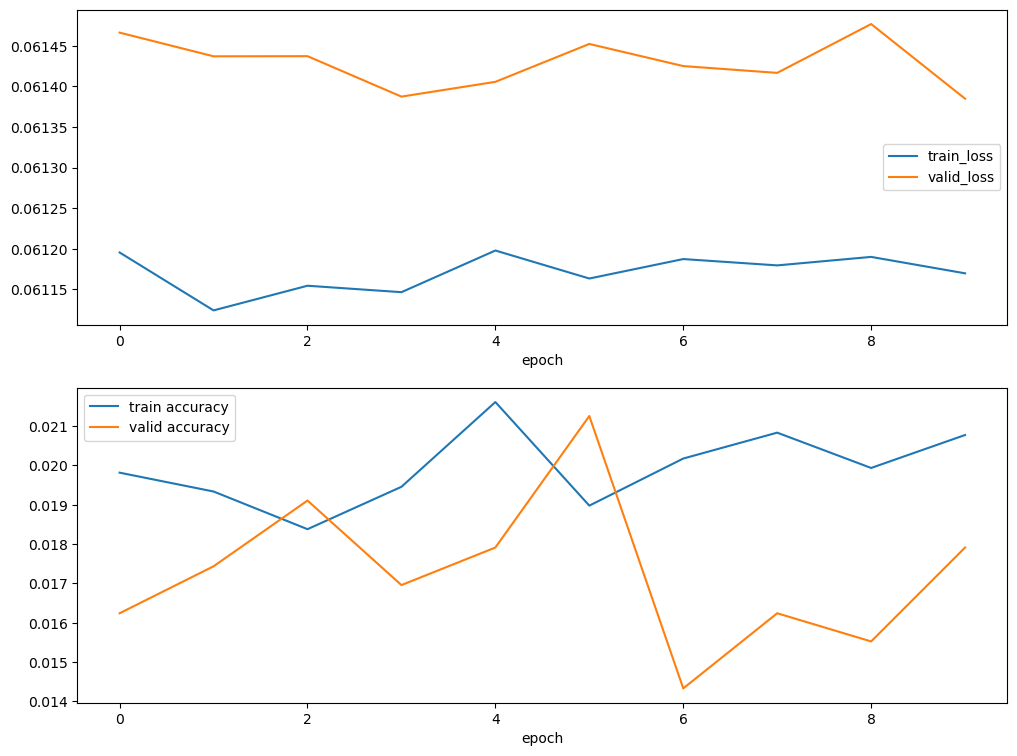

In [181]:
# plot_trainig(losses, accuracies)

## using pretrained imagenet

In [184]:
vgg_model = models.vgg19_bn(weights='DEFAULT')

In [189]:
unfreeze_layers: int = 5
for param in vgg_model.features[:-unfreeze_layers].parameters():
    param.requires_grad = False
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [190]:
num_features = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_features, classes)

In [192]:
vgg_model = vgg_model.to(device)

In [194]:
# best_model, losses, accuracies = fit(10, vgg_model, loss_fn, optim, dataloader, scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

0.05936440546339193 0.05964494632997005


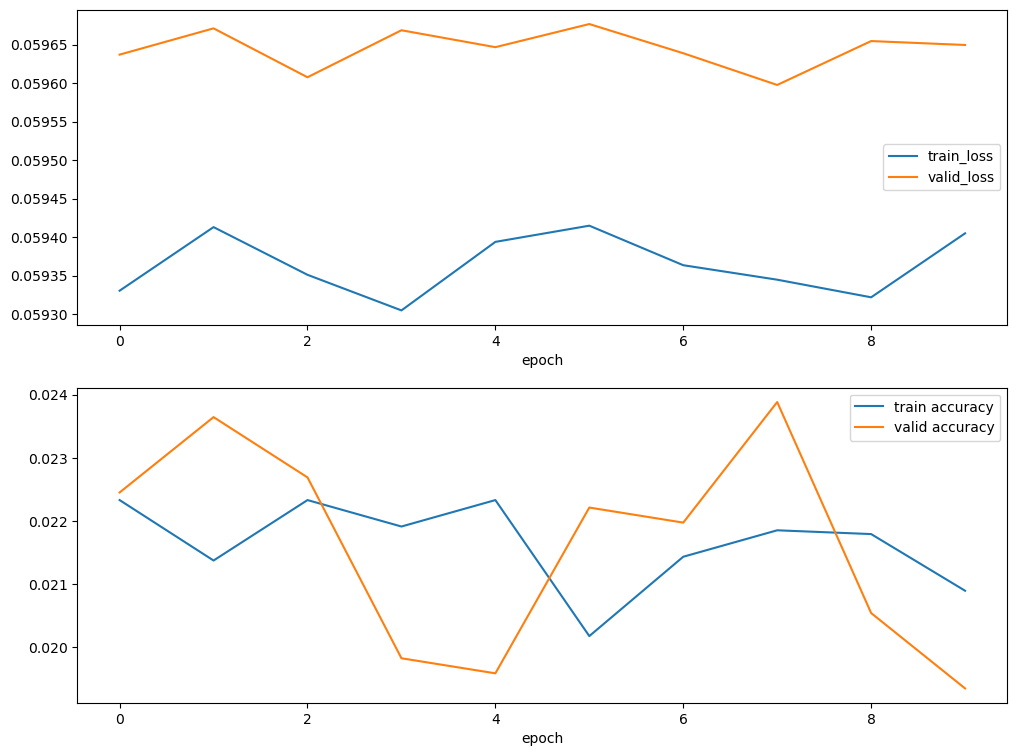

In [196]:
# plot_trainig(losses, accuracies)

## load submission to file

In [ ]:
import pandas as pd

In [ ]:
def predict_to_submission(model, dataloader_test=dataloader_test, test_filenames=test_filenames, dataset_classes=dataset_classes):
    probs = predict(model, dataloader_test)
    print(probs.shape)
    predictions = np.argmax(probs, axis=1)
    preds = dataset_classes[predictions]
    submission = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv')
    submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds}).sort_values('Id')
    submission.to_csv('./submission.csv', index=False)

In [ ]:
# predict_to_submission(best_model)